In [1]:
import sys
import scanpy as sc 
import numpy as np

sys.path.append('/home/jupyter/data/PlastiNet_v2')

from plastinet.data.data_loader import create_data_objects
from plastinet.visualization.plots import plot_continous_obs, plot_tissue, plot_composition_dot_plot, plot_expression

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: 
object has no attribute sparse_csc_tensor:
  File "/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/torch_sparse/tensor.py", line 585
            value = torch.ones(self.nnz(), dtype=dtype, device=self.device())
    
        return torch.sparse_csc_tensor(colptr, row, value, self.sizes())
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [103]:
adata = sc.read_h5ad("testing_data.h5ad") 

In [104]:
set(adata.obs["subset"])

{'epi', 'myeloids', 'plasmas', 'stroma', 'tcells'}

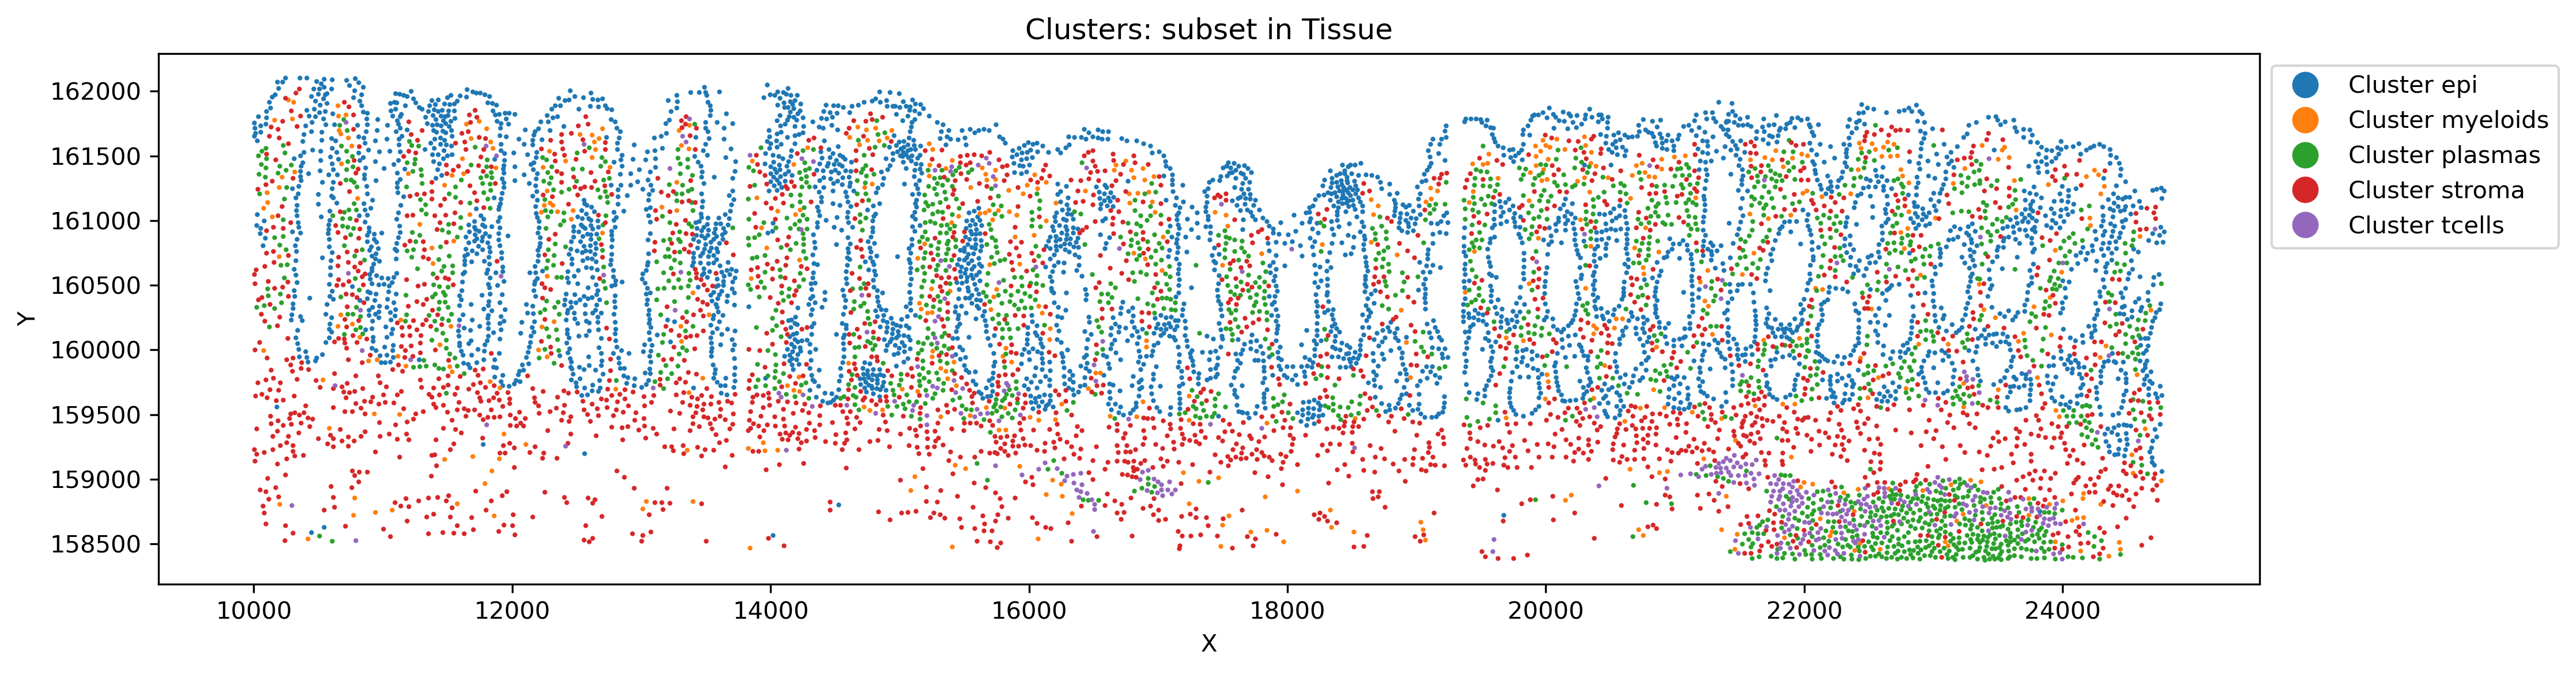

{'epi': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'myeloids': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'plasmas': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'stroma': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'tcells': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)}

In [105]:
# plot spatialy by cell type 
plot_tissue(adata, "subset", figure_size=(15, 4))

In [106]:
# ensure spatial coordinates are in the correct place 
spatial_coords = np.array([adata.obs["X"], adata.obs["Y"]]).T
adata.obsm["spatial"] = spatial_coords

# Choose appropiate radius 

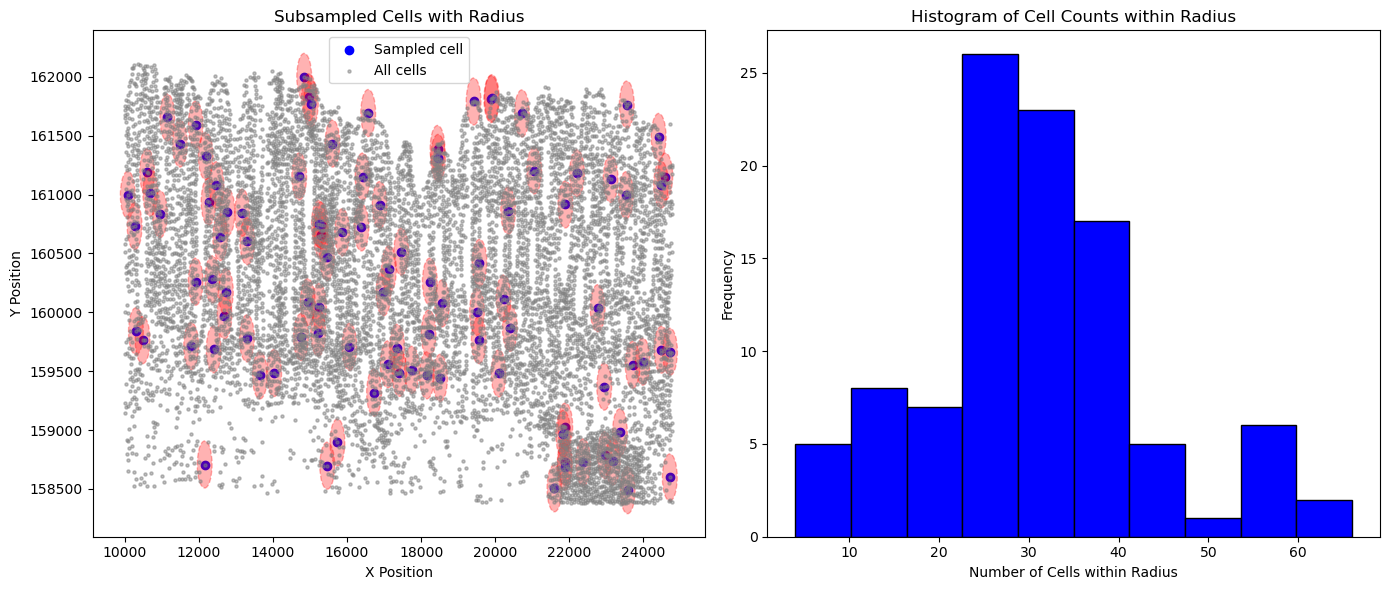

In [5]:
import plastinet.visualization.plots as plot
# select a radius that captures neighboring cells at desired resolution

plot.plot_subsample_radius(adata, x_samples = 100, radius = 200)

# Generate Embedding

Starting GAT run...
HC_b_
Model improved and parameters saved.
Epoch [1/50] Completed. Epoch Losses: DGI Loss = 1.3849, Spatial Loss = 0.5204, L1 Loss = 0.614298, Total Loss = 2.5196
Model improved and parameters saved.
Epoch [2/50] Completed. Epoch Losses: DGI Loss = 1.3749, Spatial Loss = 0.5008, L1 Loss = 0.579606, Total Loss = 2.4552
Model improved and parameters saved.
Epoch [3/50] Completed. Epoch Losses: DGI Loss = 1.3684, Spatial Loss = 0.4870, L1 Loss = 0.546015, Total Loss = 2.4014
Model improved and parameters saved.
Epoch [4/50] Completed. Epoch Losses: DGI Loss = 1.3621, Spatial Loss = 0.4852, L1 Loss = 0.514469, Total Loss = 2.3617
Model improved and parameters saved.
Epoch [5/50] Completed. Epoch Losses: DGI Loss = 1.3575, Spatial Loss = 0.4768, L1 Loss = 0.484392, Total Loss = 2.3187
Model improved and parameters saved.
Epoch [6/50] Completed. Epoch Losses: DGI Loss = 1.3535, Spatial Loss = 0.4661, L1 Loss = 0.455832, Total Loss = 2.2755
Model improved and parameters sa

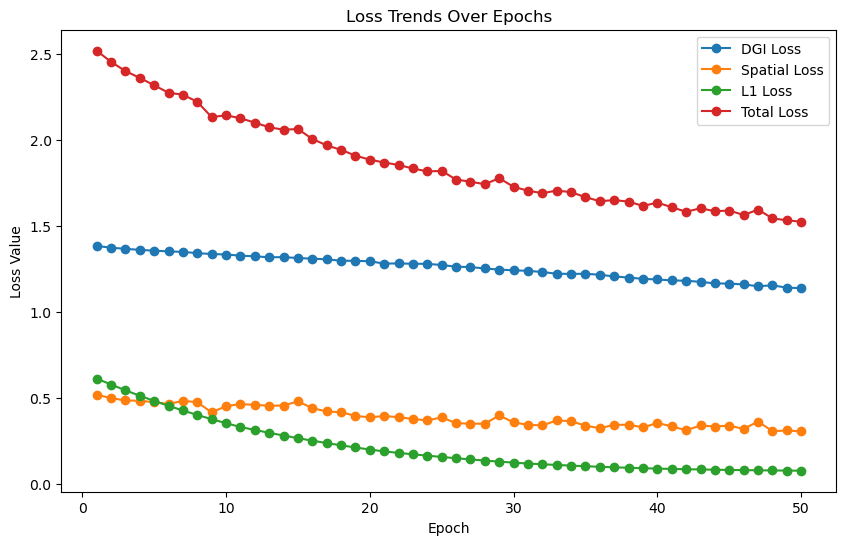

GAT run completed.


AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y', 'final_avg_pseudotime', 'pseudotime_bins', 'leiden'
    uns: 'reduction_layes', 'neighbor_attention'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [33]:
import importlib
import torch
from torch_geometric.data import DataLoader

from plastinet.models import plastinet_model
from plastinet.data import data_loader, graph_utils
from plastinet.models.plastinet_model import PlastiNet
from plastinet.data.data_loader import create_data_objects
from plastinet.data.graph_utils import graph_alpha, sparse_mx_to_torch_edge_list, graph_to_sparse_matrix

importlib.reload(plastinet_model)

plastinet = PlastiNet(
    adata=adata, # adata object
    sample_key= 'sample_source', # tissue source ID
    radius=200, # radius to consider        
    spatial_reg=2, # weighting of spatial term in loss function   
    z_dim=50,  # output feature size of embedding            
    lr=0.001,  # learning rate      
    beta_1=0.9, # self weighting in layer 1
    beta_2=0.1, # self weighting in layer 2
    alpha=5.0, # weight for stregth of distance decay 
    attention_threshold = 0.001,
    weight_decay=1e-5,  
    dropout=0.3,
    gamma=0.8, # decay in lr for each step_size incriment 
    epochs=50,
    random_seed=42,               
    patience=10,         
    mask_n = 0.7, # DGI percent of features to mask 
    spatial_percent = 0.2, # percent of cells to sample to calculate spatial loss 
    step_size = 10
)

plastinet.run_gat()

In [34]:
embedding_adata = plastinet.embedding_adata
embedding_adata

AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y', 'final_avg_pseudotime', 'pseudotime_bins', 'leiden'
    uns: 'reduction_layes', 'neighbor_attention'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [35]:
embedding_adata.write_h5ad("testing_delete_me.h5ad")

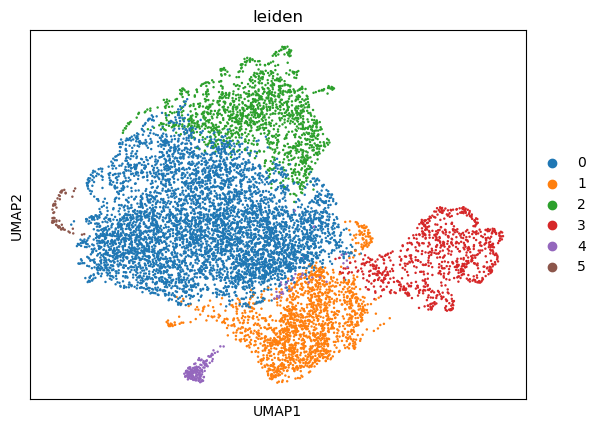

In [131]:
sc.pp.neighbors(embedding_adata, use_rep='X') 
sc.tl.umap(embedding_adata)
sc.tl.leiden(embedding_adata, resolution=0.15)
sc.pl.umap(embedding_adata, color = "leiden")

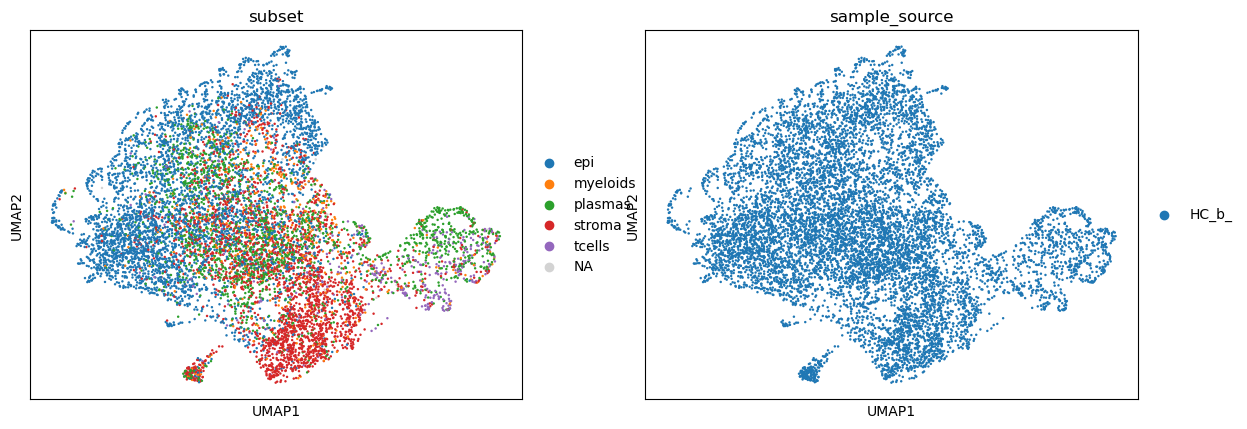

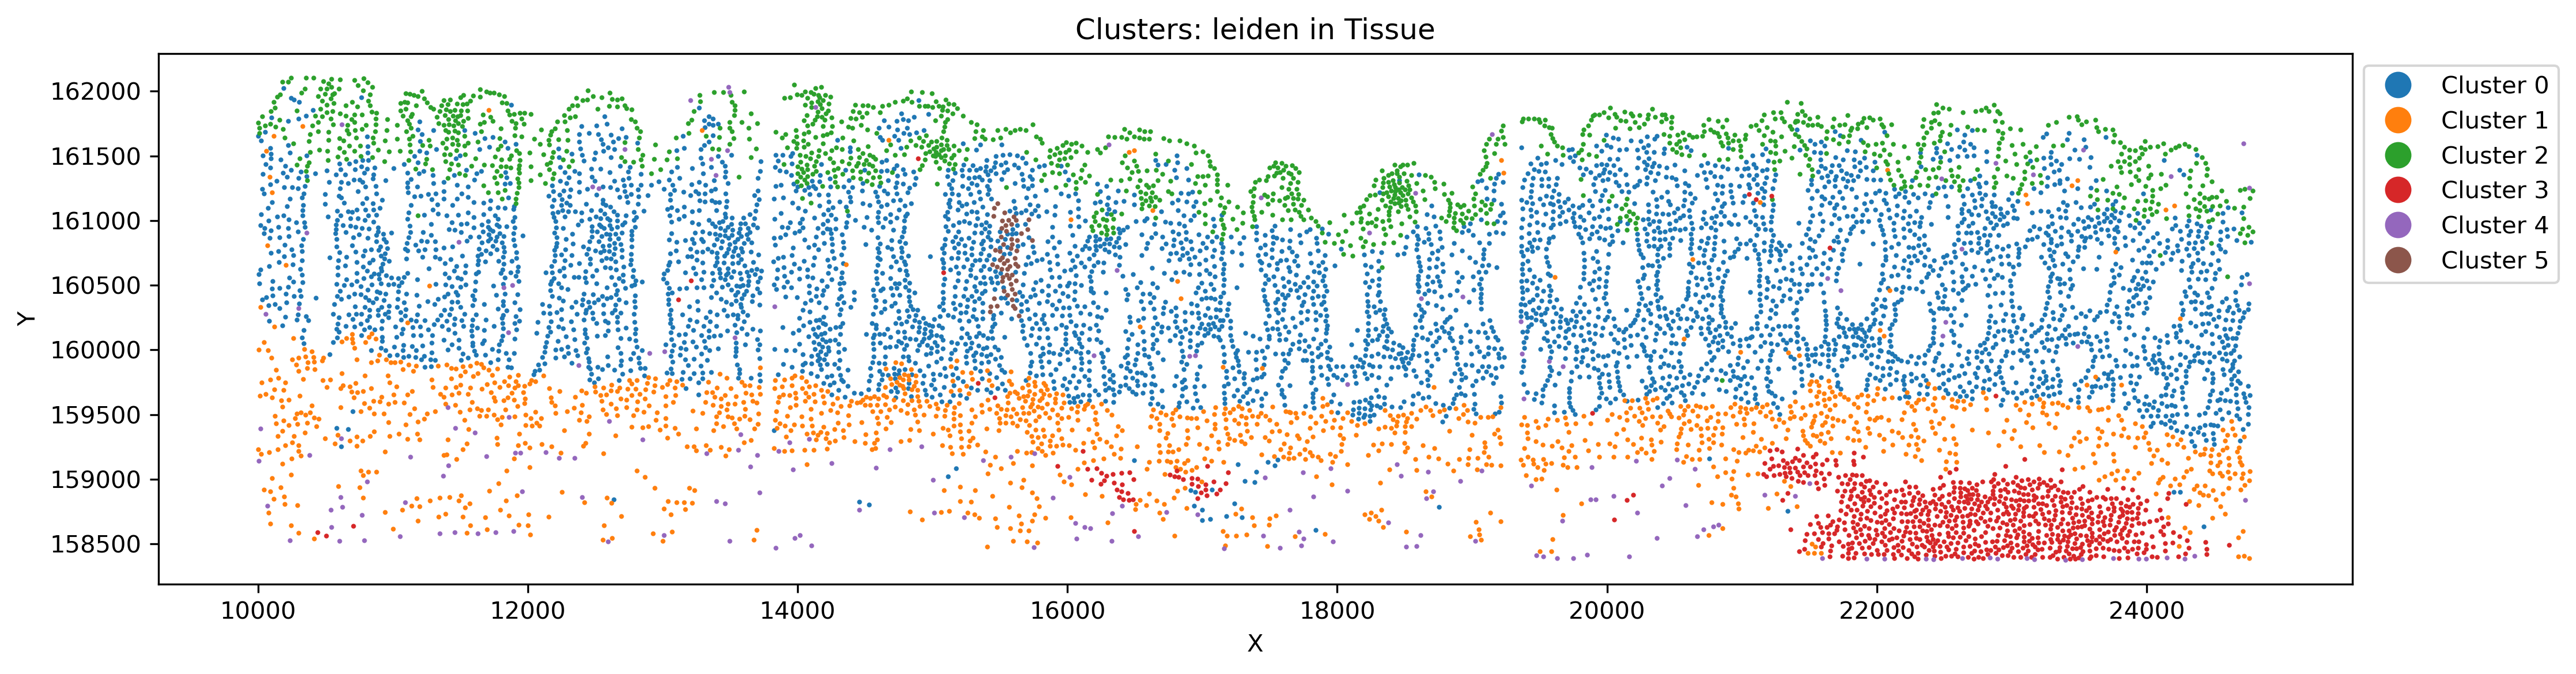

{'0': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 '1': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 '2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 '3': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 '4': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 '5': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}

In [132]:
sc.pl.umap(embedding_adata, color = ["subset", "sample_source"])
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

# Pseudotime Construction

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/jupyter/data/PlastiNet_v2/plastinet/analysis/pseudotime.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gat_epi.obs['starting_score'] = exp_epi.obs['starting_score']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


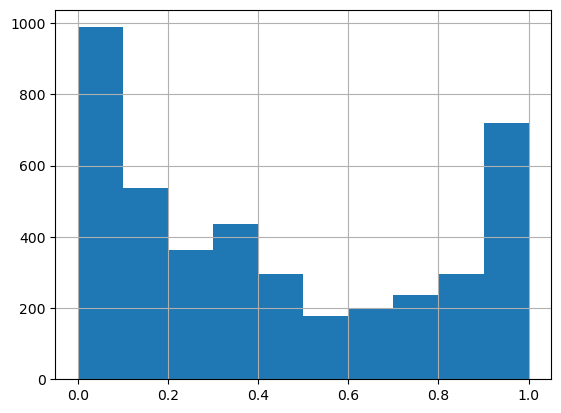

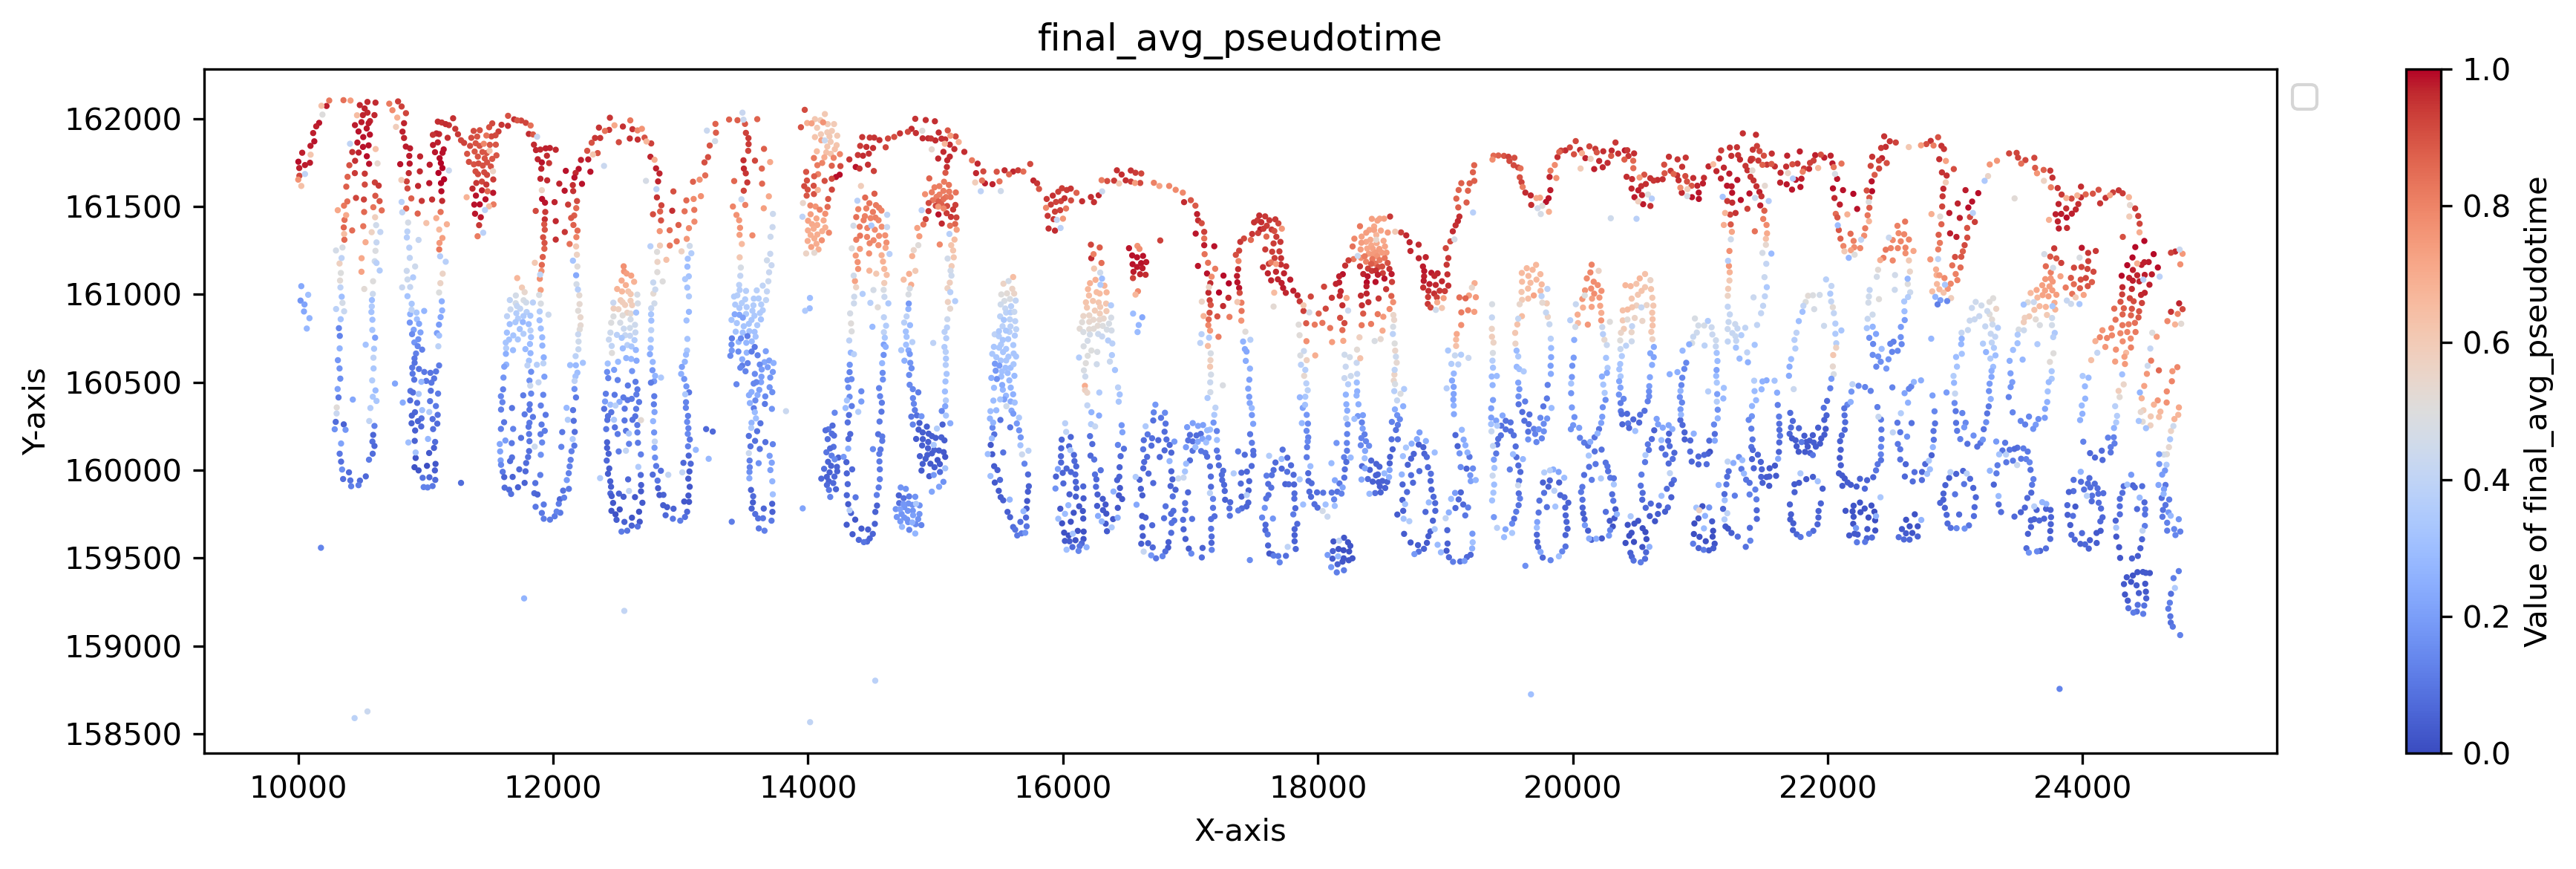

In [108]:
from plastinet.analysis import pseudotime
importlib.reload(pseudotime)

stem_cell_gene_list = ["CD44", "EPHB2", "EPHB3", "SOX9", 'ITGA1', 'ITGB1', 'ITGB2', 'ITGAX', 'ITGB4']
pseudotime.construct_differentiation_path(
    embedding_adata, 
    plastinet.adata, 
    "subset", 
    "epi", 
    stem_cell_gene_list, # starting point gene list
    None,                # ending point gene list
    N=5                 # number of starting cells 
)

plot_continous_obs(embedding_adata, "final_avg_pseudotime", size = 1, figure_size=(15, 4))

In [109]:
adata.obs["final_avg_pseudotime"] = embedding_adata.obs["final_avg_pseudotime"]

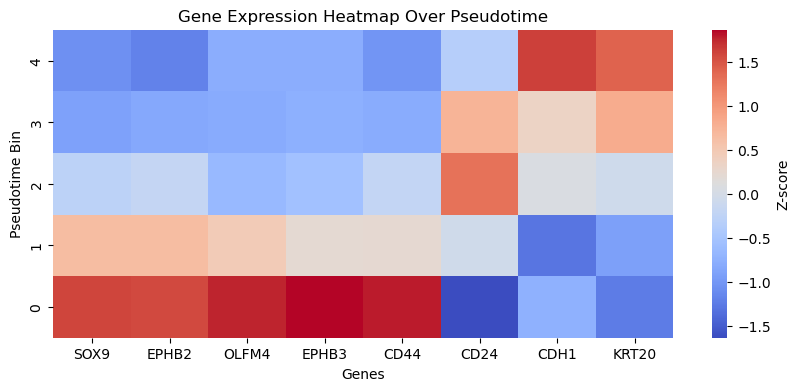

In [110]:
importlib.reload(pseudotime)

validation_genes = ["SOX9", "EPHB2","OLFM4", "EPHB3","CD44", "CD24", "CDH1", "KRT20"]

adata.obs["pseudotime_bins"] = pseudotime.plot_pseudotime_heatmap(adata, validation_genes, n_bins=5)

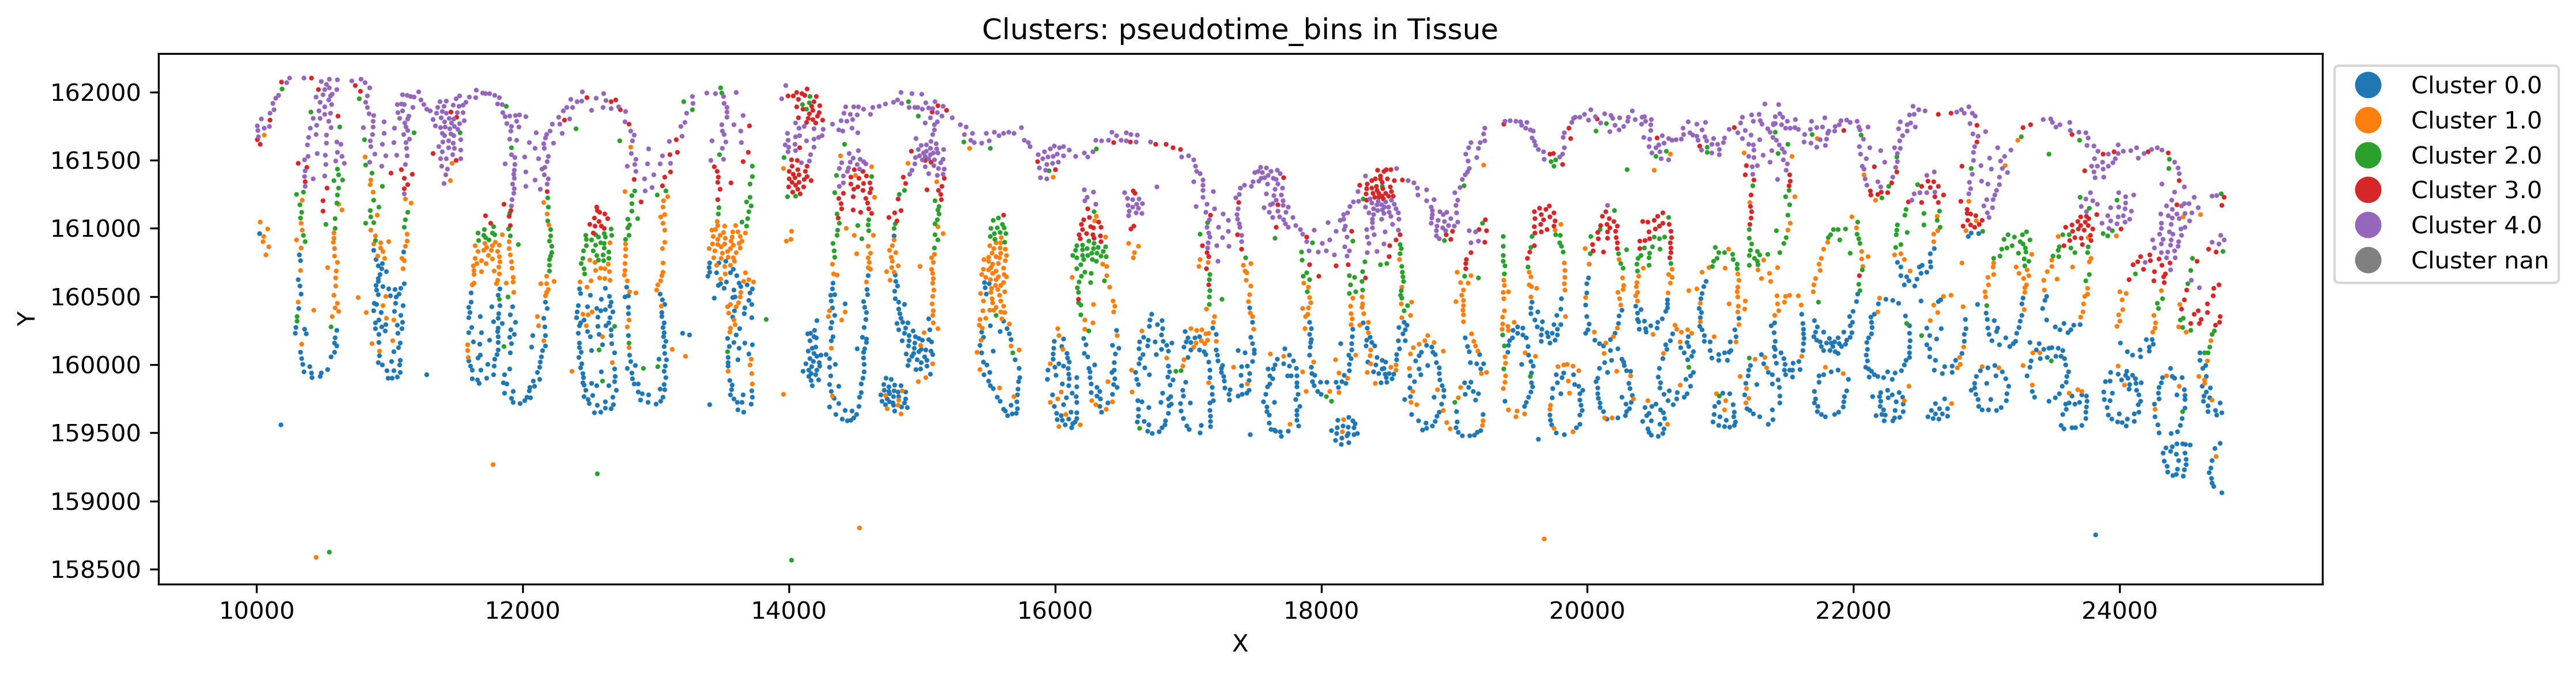

{0.0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1.0: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 2.0: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 3.0: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 4.0: (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 nan: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}

In [41]:
plot_tissue(adata, "pseudotime_bins", tabTen=True, figure_size=(15, 4))

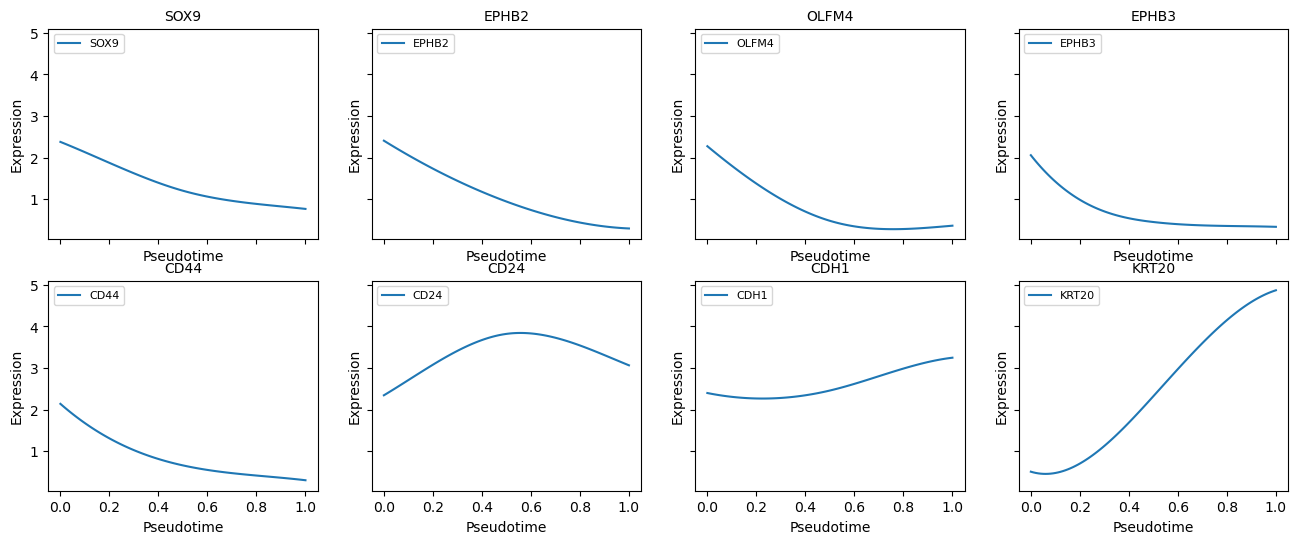

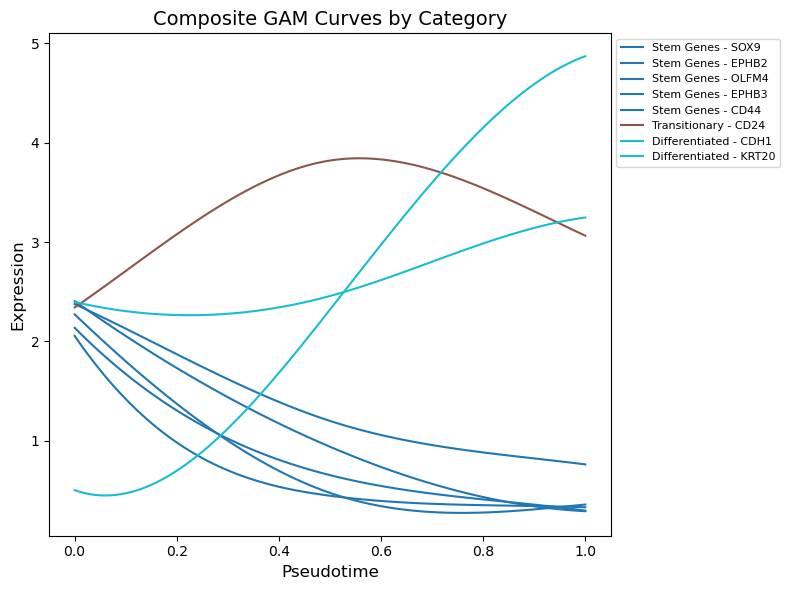

In [111]:
importlib.reload(pseudotime)


validation_genes = {"Stem Genes" : ["SOX9", "EPHB2","OLFM4", "EPHB3", "CD44"], 
                    "Transitionary":["CD24"], 
                    "Differentiated": ["CDH1", "KRT20"]} 


pseudotime.plot_gam_curves(adata, validation_genes)

# Neighborhood Analysis 

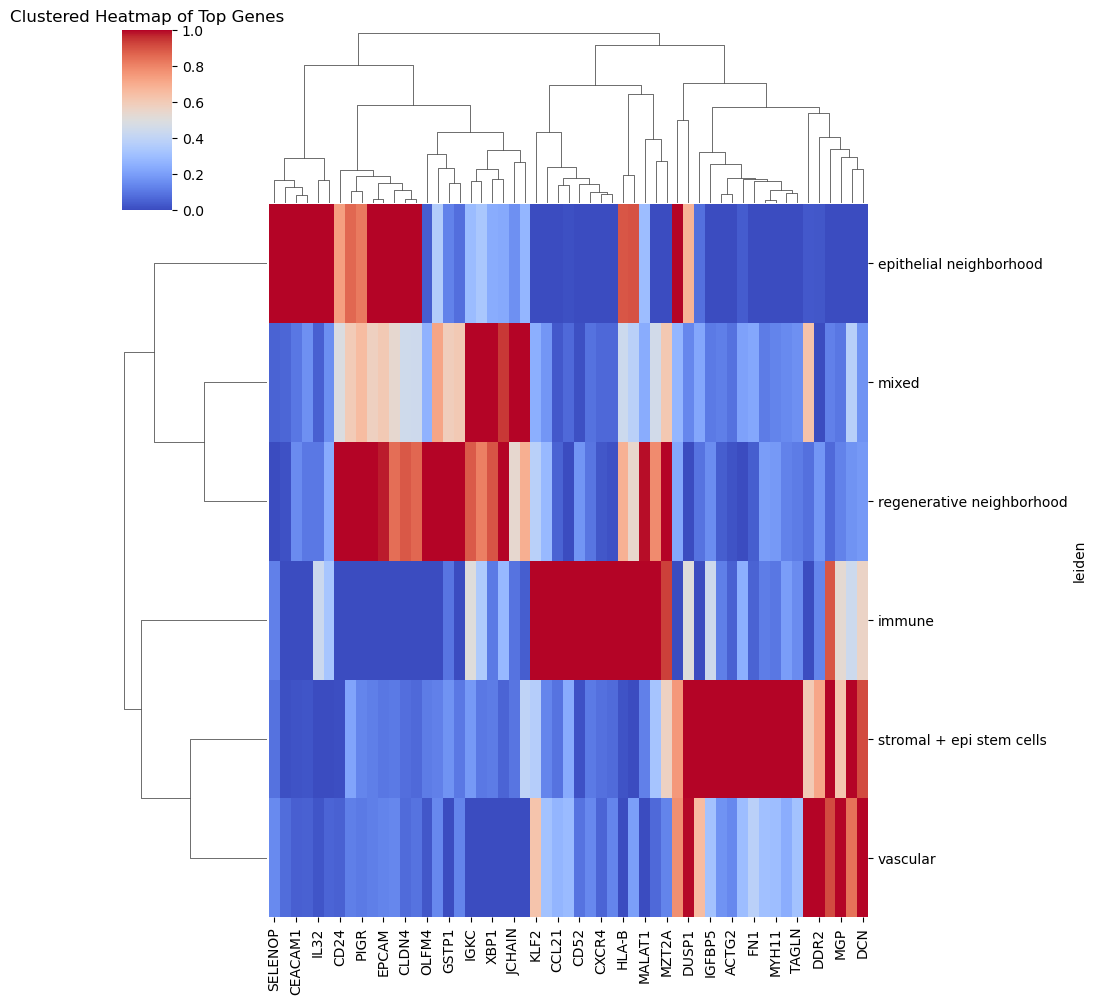

{'epithelial neighborhood': array(['KRT20', 'AQP8', 'KRT8', 'PLAC8', 'KRT19', 'CEACAM1', 'SELENOP',
        'CLDN4', 'IL32', 'LGALS3'], dtype=object),
 'mixed': array(['IGHA1', 'IGKC', 'JCHAIN', 'ITLN1', 'AGR2', 'PIGR', 'DUSP5',
        'GSTP1', 'XBP1', 'HSP90B1'], dtype=object),
 'stromal + epi stem cells': array(['TAGLN', 'ACTA2', 'TPM2', 'MYH11', 'IGFBP5', 'ACTG2', 'MYL9',
        'CALD1', 'C11orf96', 'FN1'], dtype=object),
 'vascular': array(['DUSP1', 'DCN', 'IGFBP7', 'MGP', 'CFD', 'KLF2', 'C11orf96', 'CLU',
        'DDR2', 'GSN'], dtype=object),
 'immune': array(['CD74', 'CXCR4', 'CCL21', 'CD37', 'RPL21', 'HLA-A', 'HLA-B',
        'PTGDS', 'HLA-DRA', 'CD52'], dtype=object),
 'regenerative neighborhood': array(['PIGR', 'S100A6', 'MALAT1', 'LGALS3', 'EPCAM', 'MZT2A', 'KRT19',
        'KRT8', 'CD24', 'OLFM4'], dtype=object)}

In [137]:
from plastinet.analysis import neighborhood_analysis
importlib.reload(neighborhood_analysis)

adata.obs["leiden"] = embedding_adata.obs["leiden"]

neighborhood_analysis.plot_top_genes_leiden(adata)

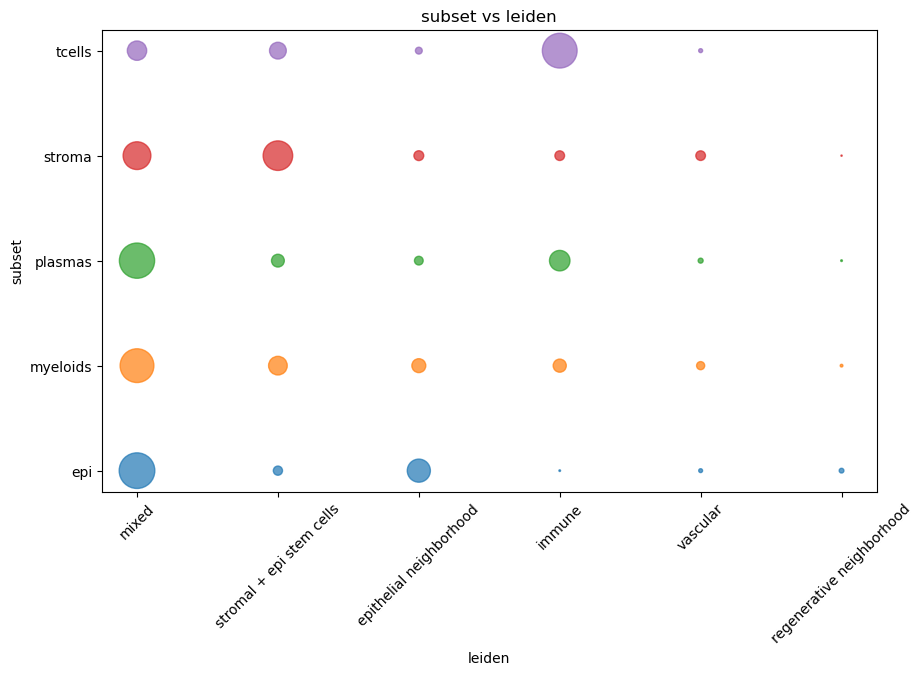

In [138]:
plot.plot_composition_dot_plot(adata, 'leiden', 'subset')

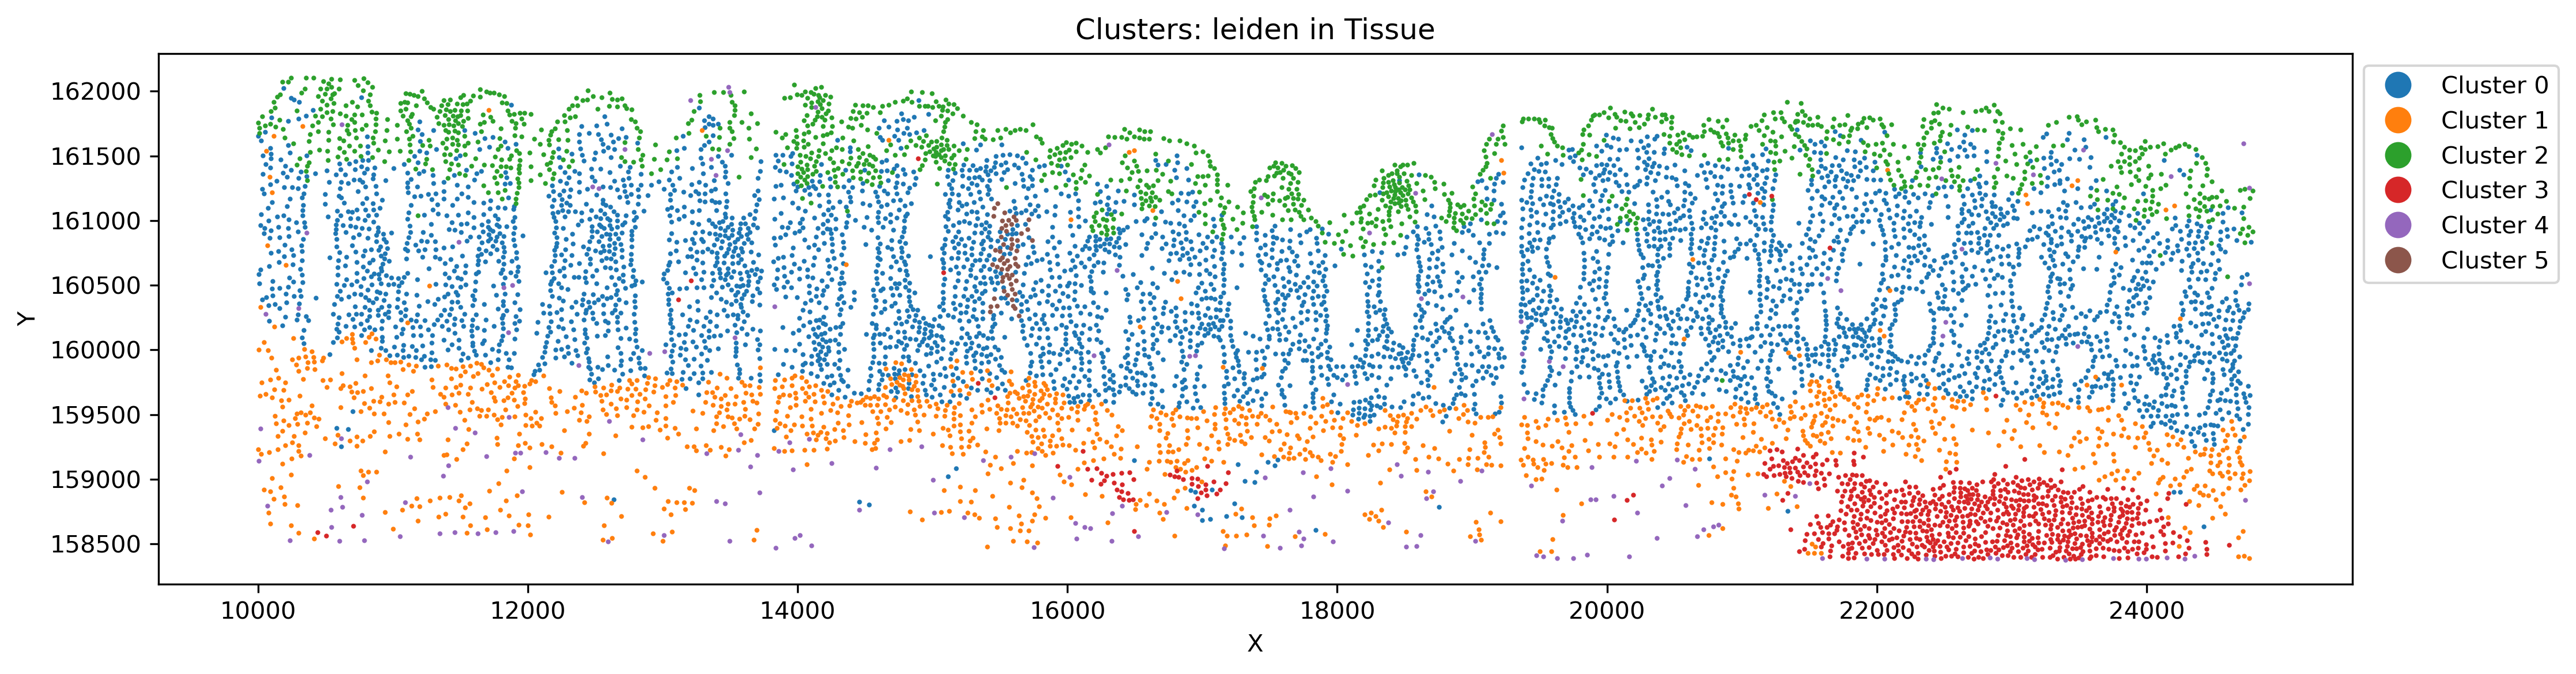

{'0': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 '1': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 '2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 '3': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 '4': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 '5': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}

In [135]:
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

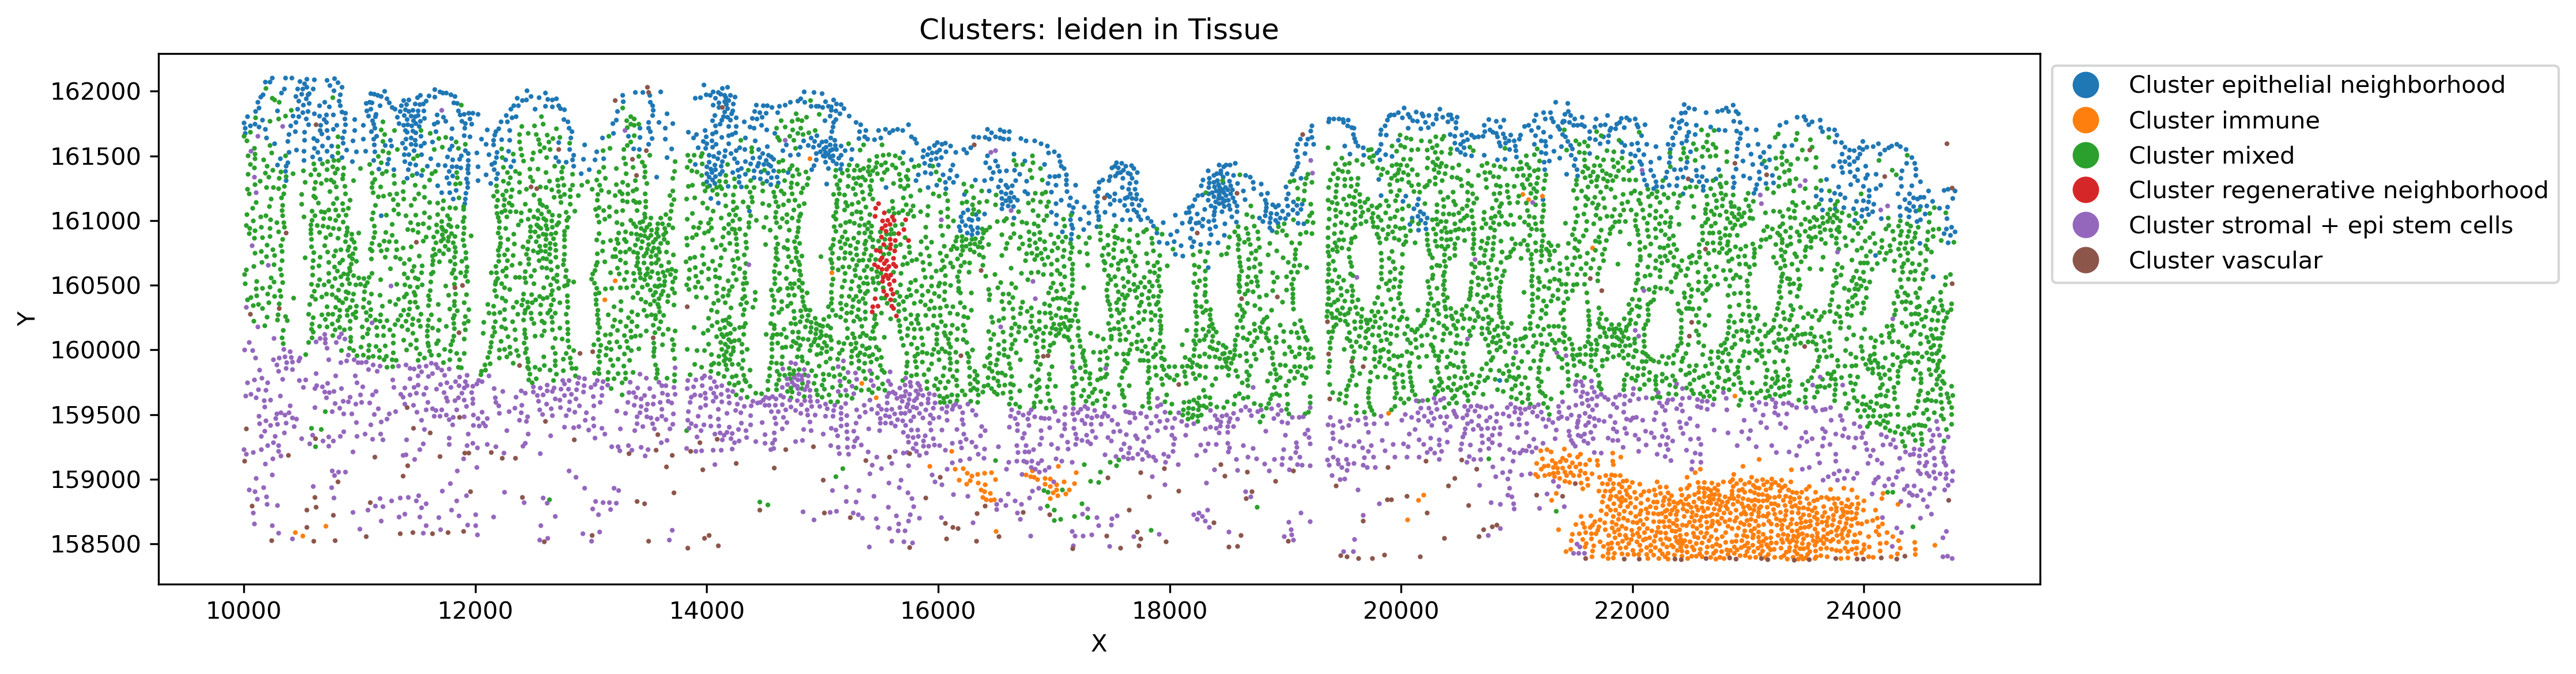

{'epithelial neighborhood': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'immune': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'mixed': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'regenerative neighborhood': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'stromal + epi stem cells': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'vascular': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  1.0)}

In [136]:
label_mapping = {
    "0": "mixed",
    "1": "stromal + epi stem cells",
    "2": "epithelial neighborhood",
    "3": "immune",
    "4": "vascular",
    "5": "regenerative neighborhood"
}

embedding_adata.obs["leiden"] = embedding_adata.obs["leiden"].map(label_mapping)
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

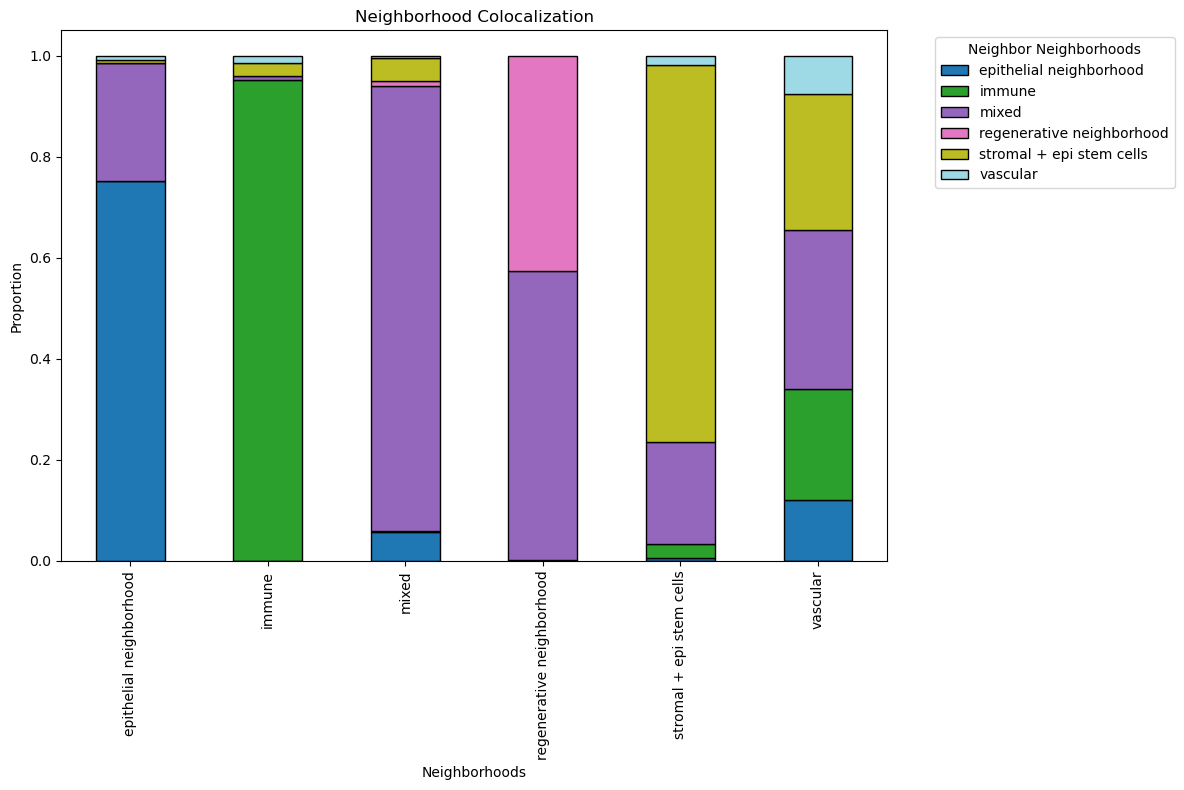

In [147]:
importlib.reload(neighborhood_analysis)

neighbor_colocalization = neighborhood_analysis.calculate_neighborhood_colocalization(embedding_adata)

neighborhood_analysis.plot_neighborhood_colocalization(neighbor_colocalization)

# Spatial Co Localization

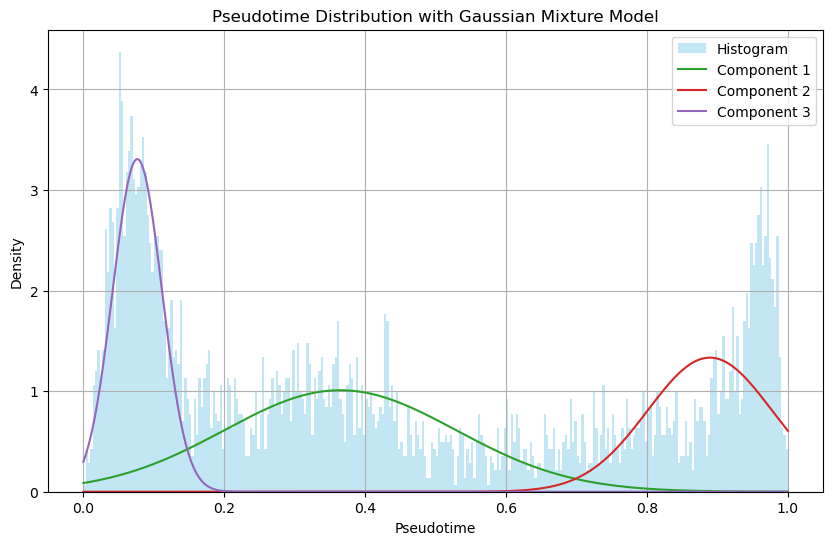

In [68]:

from plastinet.analysis import spatial_colocalization
importlib.reload(spatial_colocalization)

spatial_colocalization.gmm_discretize_pseudotime(embedding_adata, 
                                                 "final_avg_pseudotime", 
                                                 n_components=3, 
                                                 output_label_key="GMM_labels", 
                                                 plot=True)

In [87]:
label_mapping = {
    1.0: "Transitionary",
    3.0: "Stem",
    2.0: "Differentiated"
}

embedding_adata.obs["GMM_labels"] = embedding_adata.obs["GMM_labels"].map(label_mapping)

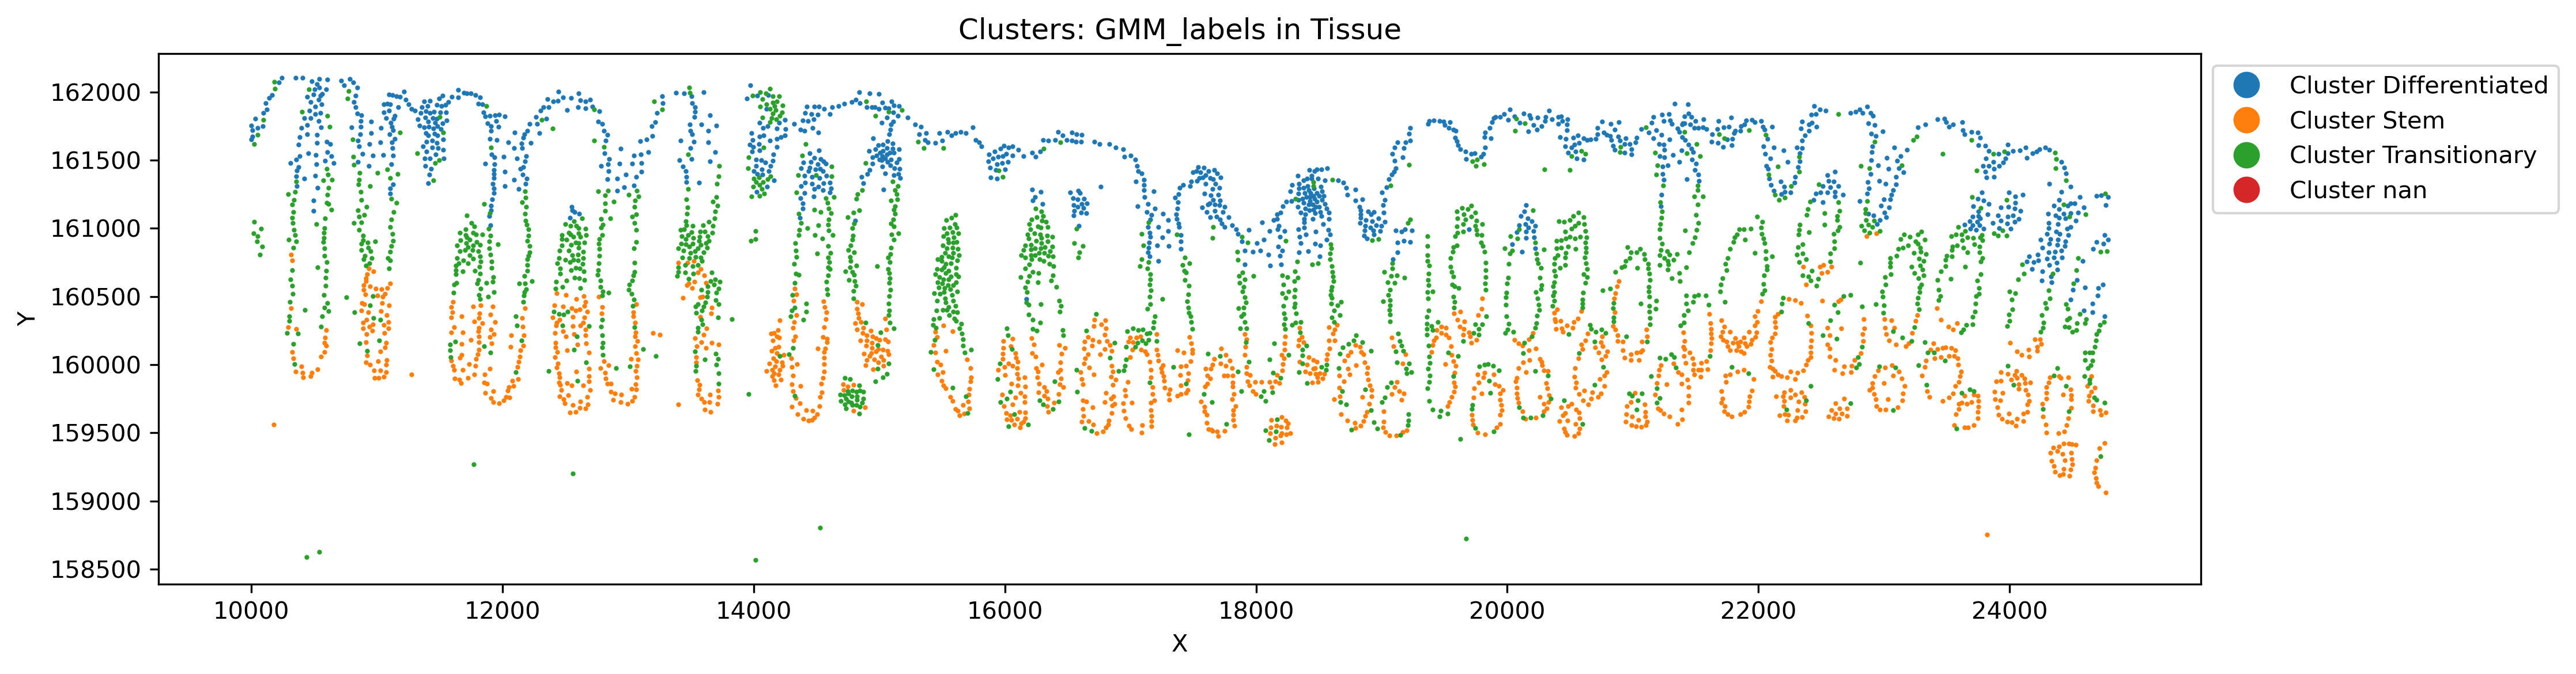

{'Differentiated': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'Stem': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'Transitionary': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 nan: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)}

In [91]:

plot_tissue(embedding_adata, "GMM_labels", figure_size=(15, 4))

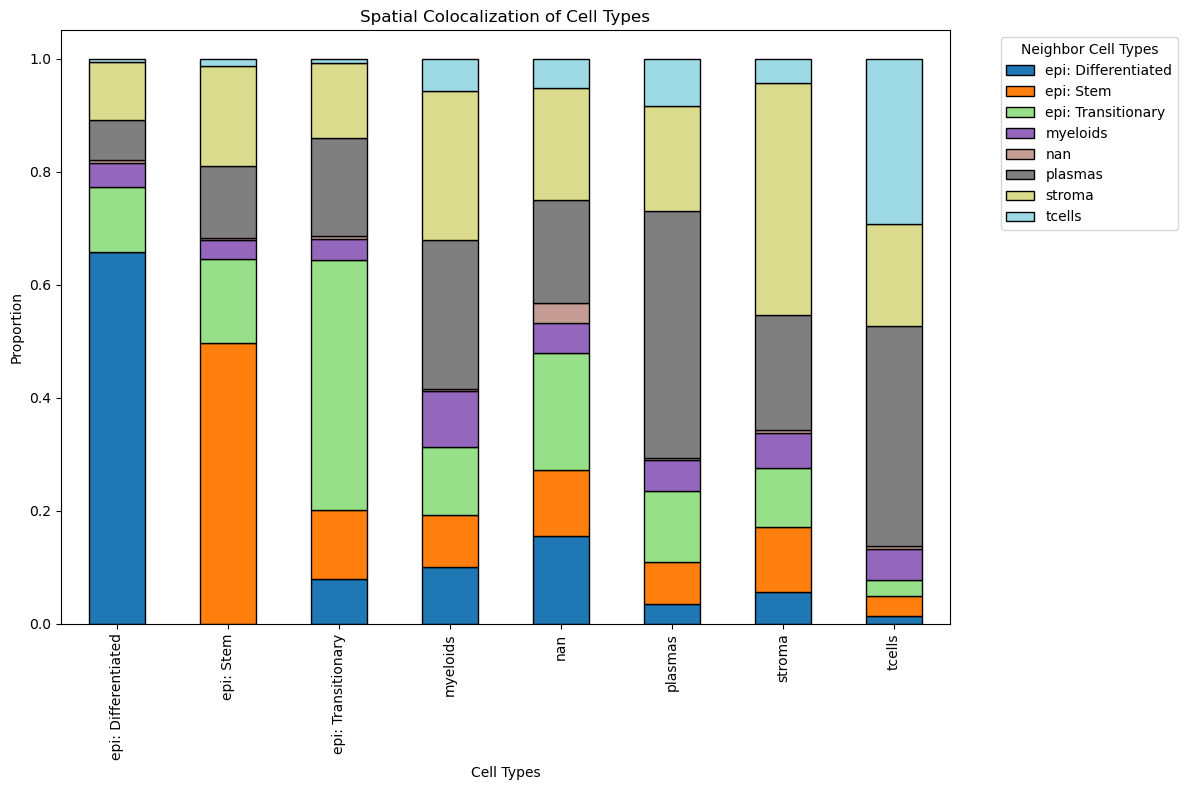

In [92]:

importlib.reload(spatial_colocalization)

output = spatial_colocalization.calculate_colocalization(embedding_adata, 
                                                x_key="X", 
                                                y_key="Y", 
                                                cell_type_key="subset", 
                                                subtype_key="GMM_labels", 
                                                radius=200)

spatial_colocalization.plot_stacked_colocalization(output, normalize=True)

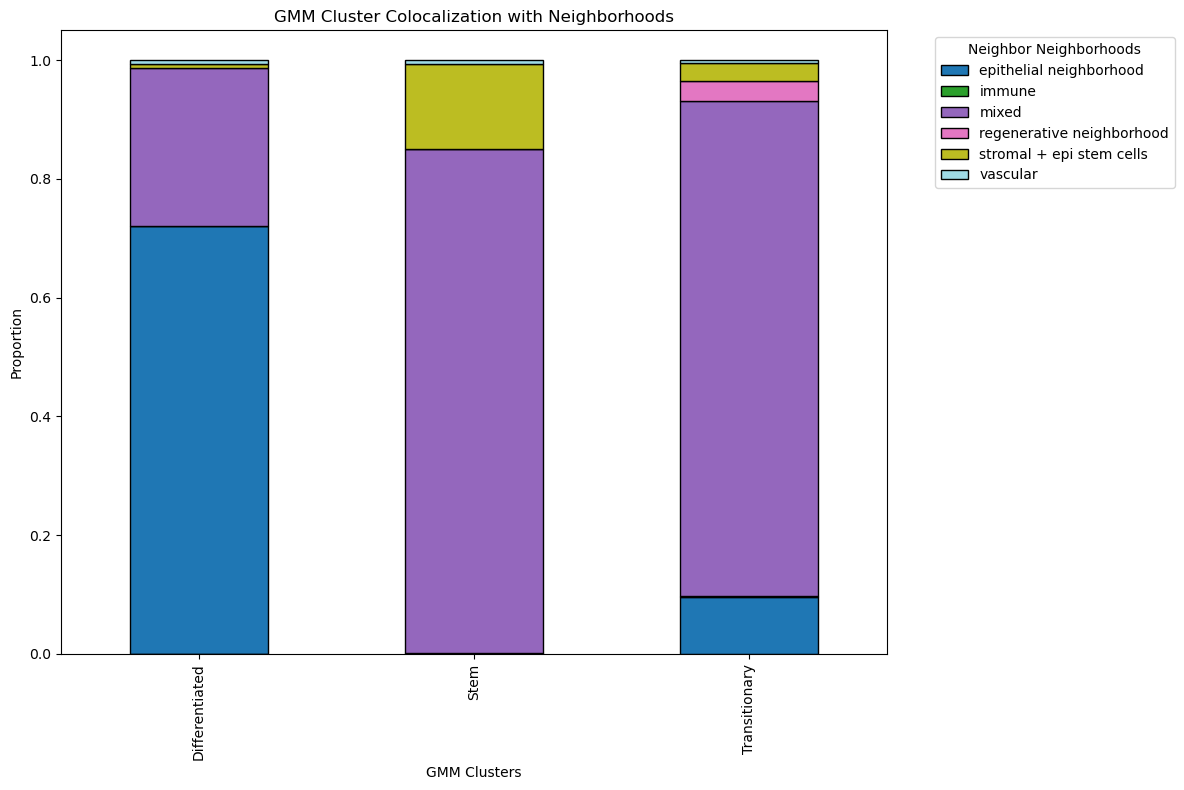

In [159]:

importlib.reload(spatial_colocalization)
gmm_colocalization = spatial_colocalization.calculate_gmm_colocalization(
    adata=embedding_adata,
    x_key="X",
    y_key="Y",
    leiden_key="leiden",
    gmm_key="GMM_labels",
    radius=200
)
spatial_colocalization.plot_gmm_colocalization(gmm_colocalization)


In [161]:
importlib.reload(spatial_colocalization)

# Calculate Morgan's I 
# I>0: Positive spatial autocorrelation (similar values are spatially clustered)
# I=0: No spatial autocorrelation (random spatial distribution)
# I<0: Negative spatial autocorrelation (dissimilar values are spatially clustered)

spatial_colocalization.compute_spatial_autocorrelation(embedding_adata,
                                x_key="X",
                                y_key="Y",
                                gmm_key="GMM_labels")

Differentiated    0.186482
Transitionary     0.078812
Stem              0.159685
dtype: float64

# Attention Analysis

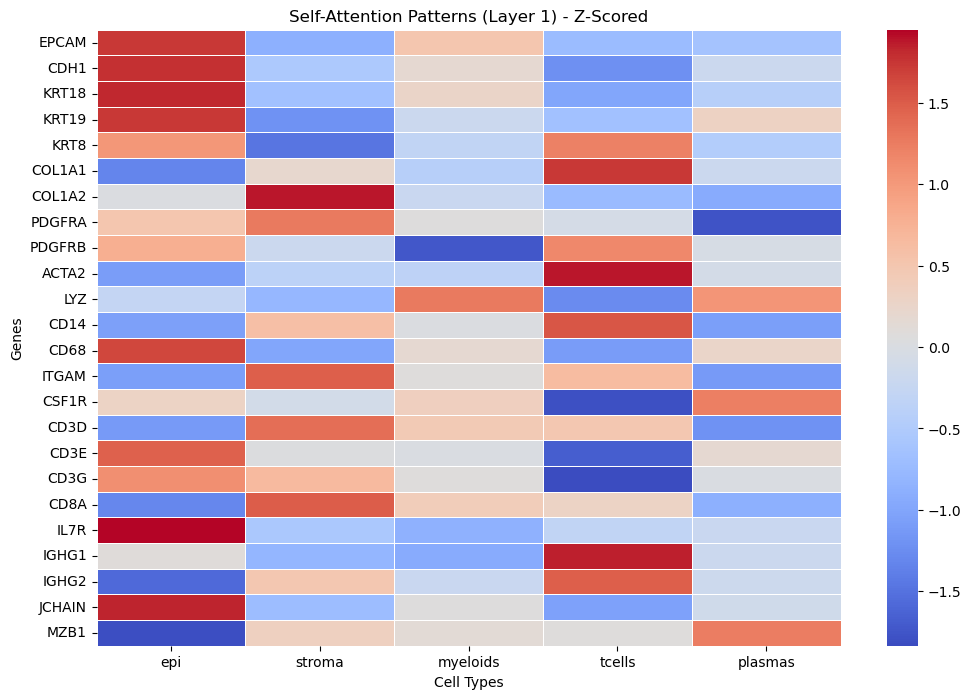

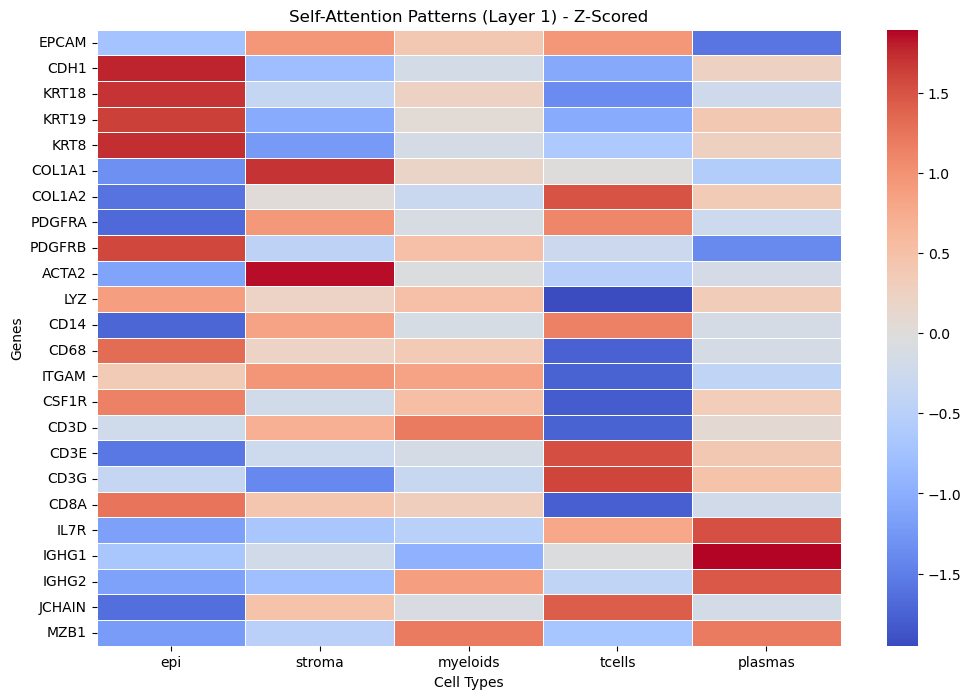

In [50]:
from plastinet.analysis import attention_analysis
importlib.reload(attention_analysis)


marker_genes = ["EPCAM", "CDH1", "KRT18", "KRT19", "KRT8",
               "COL1A1", "COL1A2", "PDGFRA", "PDGFRB", "ACTA2",
                "LYZ", "CD14", "CD68", "ITGAM", "CSF1R",
                "CD3D", "CD3E", "CD3G", "CD8A", "IL7R", 
                "IGHG1", "IGHG2", "JCHAIN", "MZB1"]

attention_analysis.analyze_self_attention_layer(embedding_adata, adata, gene_list = marker_genes, normalize=True, layer = "1")
attention_analysis.analyze_self_attention_layer(embedding_adata, adata, gene_list = marker_genes, normalize=True, layer = "2")

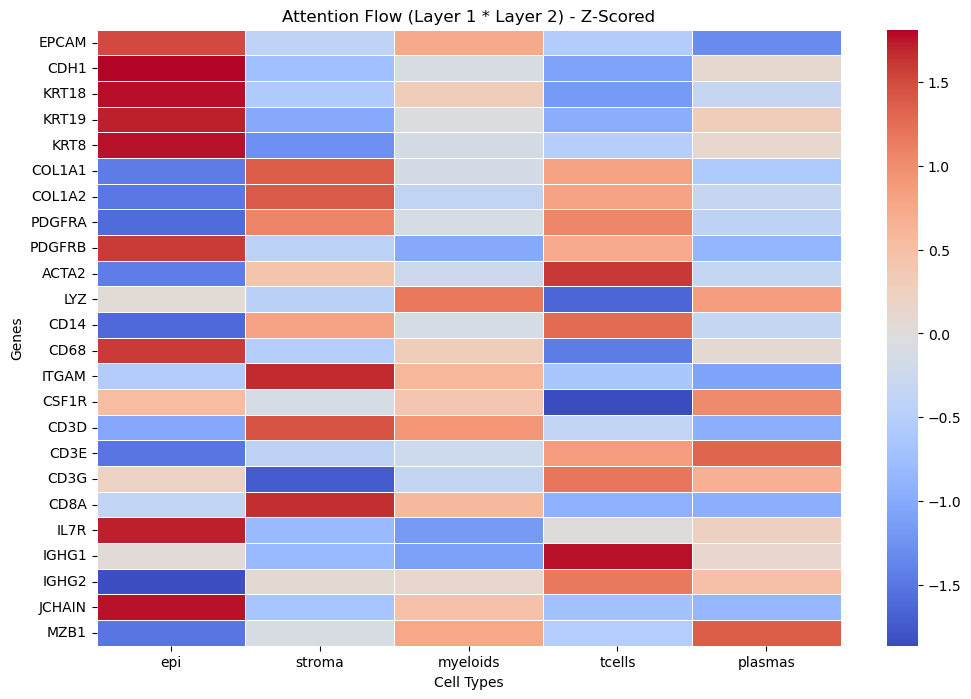

epi    stroma  myeloids    tcells   plasmas
EPCAM   1.507931 -0.401759  0.748321 -0.549633 -1.304858
CDH1    1.810586 -0.740534 -0.106395 -1.072485  0.108830
KRT18   1.768421 -0.580351  0.295216 -1.159171 -0.324115
KRT19   1.722695 -1.003131 -0.051464 -0.966593  0.298494
KRT8    1.766904 -1.262788 -0.133224 -0.499204  0.128312
COL1A1 -1.448597  1.374784 -0.146530  0.805077 -0.584733
COL1A2 -1.483146  1.383890 -0.374227  0.799320 -0.325836
PDGFRA -1.599495  1.067117 -0.111930  1.057947 -0.413639
PDGFRB  1.581642 -0.440542 -1.006602  0.733375 -0.867897
ACTA2  -1.443112  0.425507 -0.247859  1.600781 -0.335317
LYZ     0.055100 -0.443375  1.178503 -1.639960  0.849731
CD14   -1.613501  0.801993 -0.122150  1.273874 -0.340216
CD68    1.589125 -0.514588  0.291577 -1.454980  0.088868
ITGAM  -0.542689  1.669585  0.592269 -0.648114 -1.071047
CSF1R   0.540831 -0.124319  0.417647 -1.860983  1.026820
CD3D   -1.026808  1.434358  0.919771 -0.379560 -0.947755
CD3E   -1.513832 -0.426051 -0.233433  0.851394  1.321904
CD3G    0.209003 -1.721157 -0.352554  1.188363  0.676339
CD8A   -0.365597  1.666191  0.575118 -0.926821 -0.948889
IL7R    1.711274 -0.809487 -1.163230  0.010325  0.251123
IGHG1   0.039424 -0.810927 -1.114568  1.755424  0.130638
IGHG2  -1.842086  0.071078  0.121585  1.161302  0.488121
JCHAIN  1.758165 -0.668248  0.476271 -0.716001 -0.850182
MZB1   -1.507133 -0.109544  0.761580 -0.513451  1.368545

In [48]:
importlib.reload(attention_analysis)

attention_analysis.analyze_attention_flow(
    embedding_adata, 
    adata, 
    cell_type_col='subset', 
    gene_list=marker_genes,
    normalize=True, 
)

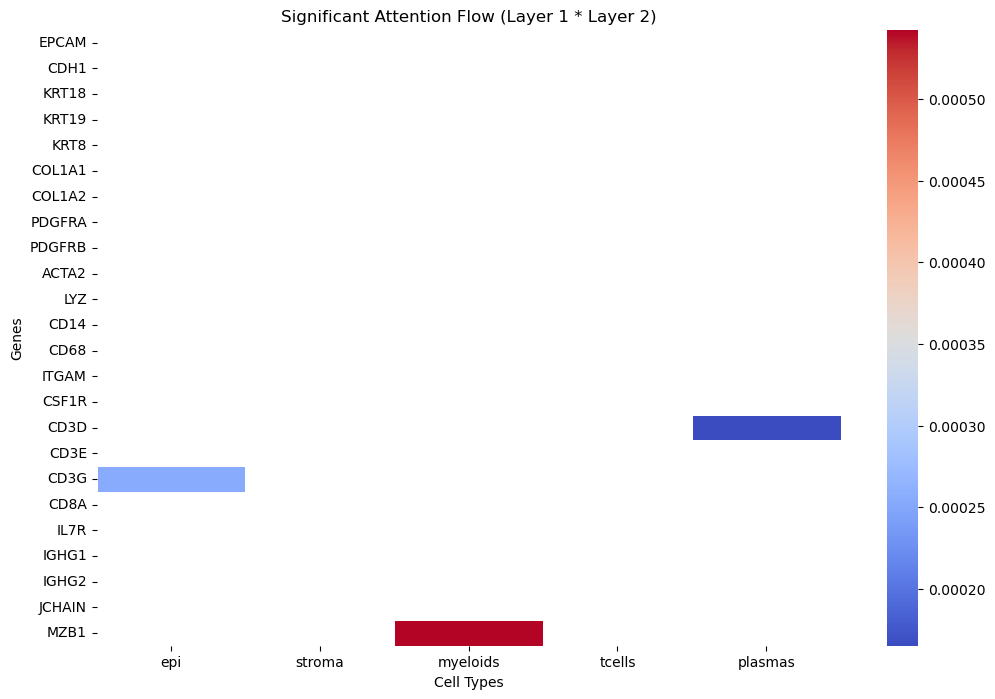

epi  stroma  myeloids  tcells  plasmas
EPCAM   1.000   0.328     0.990   0.818    0.588
CDH1    0.609   0.789     0.903   0.987    0.971
KRT18   0.982   1.000     0.980   0.732    1.000
KRT19   1.000   1.000     0.862   0.227    0.929
KRT8    1.000   0.994     0.996   0.993    0.998
COL1A1  0.844   0.991     0.438   0.993    0.761
COL1A2  0.853   1.000     0.759   1.000    0.998
PDGFRA  1.000   0.508     0.750   0.999    0.966
PDGFRB  1.000   0.560     0.998   1.000    0.981
ACTA2   0.911   0.908     0.721   1.000    1.000
LYZ     0.998   1.000     0.905   0.397    0.994
CD14    1.000   0.983     0.973   1.000    0.192
CD68    0.869   0.860     0.997   0.898    0.233
ITGAM   1.000   0.987     0.770   0.927    1.000
CSF1R   0.971   1.000     1.000   0.995    0.972
CD3D    0.095   1.000     0.945   0.988    0.040
CD3E    1.000   1.000     1.000   0.983    0.667
CD3G    0.026   0.189     0.982   1.000    1.000
CD8A    0.987   0.825     0.908   0.088    1.000
IL7R    0.463   0.795     0.613   1.000    0.728
IGHG1   0.789   0.679     0.639   1.000    0.276
IGHG2   0.857   0.964     1.000   0.140    1.000
JCHAIN  0.996   0.911     1.000   0.902    0.999
MZB1    0.847   0.748     0.010   1.000    1.000

In [162]:
# attemtping to include sig 

importlib.reload(attention_analysis)

attention_analysis.analyze_attention_flow_with_permutation(
    embedding_adata, adata, cell_type_col='subset', 
    gene_list=marker_genes,
)

Skipping invalid int_idx: 983
Skipping invalid int_idx: 7031
Skipping invalid int_idx: 964
Skipping invalid int_idx: 7019
Skipping invalid int_idx: 954
Skipping invalid int_idx: 7216
Skipping invalid int_idx: 7219
Skipping invalid int_idx: 7082
Skipping invalid int_idx: 984
Skipping invalid int_idx: 7130
Skipping invalid int_idx: 7146
Skipping invalid int_idx: 7126
Skipping invalid int_idx: 968
Skipping invalid int_idx: 7052
Skipping invalid int_idx: 7220
Skipping invalid int_idx: 3555
Skipping invalid int_idx: 7072
Skipping invalid int_idx: 7044
Skipping invalid int_idx: 7023
Skipping invalid int_idx: 1051
Skipping invalid int_idx: 7008
Skipping invalid int_idx: 3567
Skipping invalid int_idx: 3661
Skipping invalid int_idx: 1072
Skipping invalid int_idx: 6984
Skipping invalid int_idx: 7156
Skipping invalid int_idx: 3515
Skipping invalid int_idx: 3539
Skipping invalid int_idx: 1061
Skipping invalid int_idx: 7225
Skipping invalid int_idx: 7056
Skipping invalid int_idx: 3577
Skipping inva

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


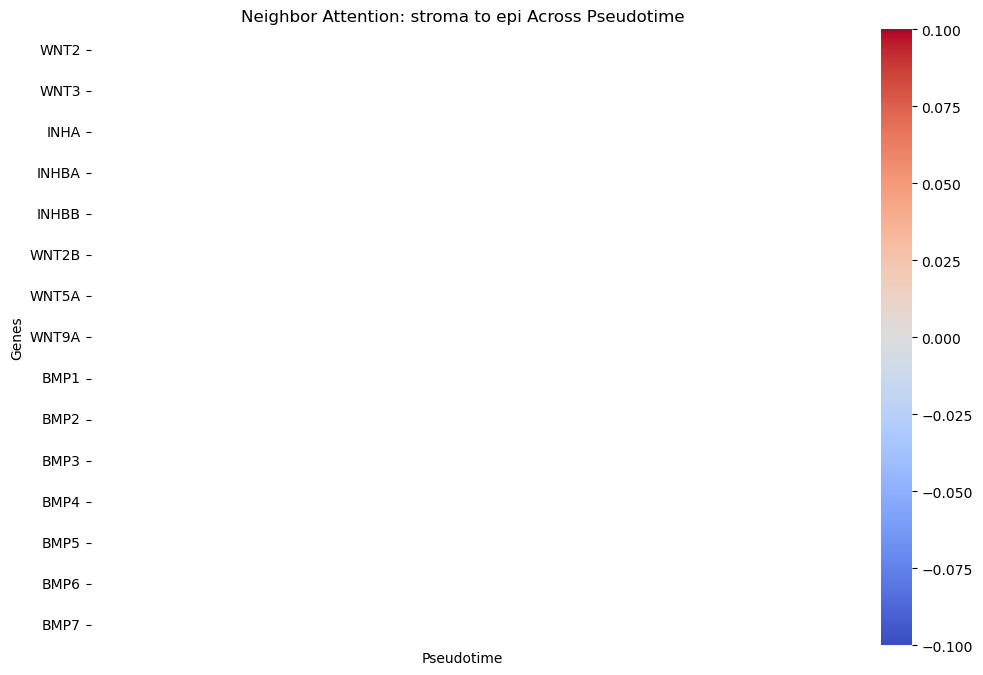

WNT2  WNT3  INHA  INHBA  INHBB  WNT2B  WNT5A  WNT9A  BMP1  BMP2  \
0.000000   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.003545   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.004786   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.005714   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.009678   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
...        ...   ...   ...    ...    ...    ...    ...    ...   ...   ...   
0.998408   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.998637   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.999319   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
0.999358   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   
1.000000   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   

          BMP3  BMP4  BMP5  BMP6  BMP7  
0.000000   NaN   NaN   NaN   NaN   NaN  
0.003545   NaN   NaN   NaN   NaN   NaN  
0.004786   NaN   NaN   NaN   NaN   NaN  
0.005714   NaN   NaN   NaN   NaN   NaN  
0.009678   NaN   NaN   NaN   NaN   NaN  
...        ...   ...   ...   ...   ...  
0.998408   NaN   NaN   NaN   NaN   NaN  
0.998637   NaN   NaN   NaN   NaN   NaN  
0.999319   NaN   NaN   NaN   NaN   NaN  
0.999358   NaN   NaN   NaN   NaN   NaN  
1.000000   NaN   NaN   NaN   NaN   NaN  

[4251 rows x 15 columns]

In [32]:
importlib.reload(attention_analysis)


attention_analysis.analyze_stromal_to_epi_attention(
    embedding_adata,
    adata,
    pseudotime_key= "final_avg_pseudotime",
    cell_type_col= "subset",
    source_type= "stroma",
    target_type= "epi",
    gene_list= ["WNT2","WNT3","INHA","INHBA","INHBB","WNT2B","WNT5A","WNT9A","BMP1","BMP2","BMP3","BMP4","BMP5","BMP6","BMP7"],
    normalize= True,
)